# LLM - Detect AI Generated Text

This competition challenges participants to develop a machine learning model that can accurately detect whether an essay was written by a student or an LLM. The competition dataset comprises a mix of student-written essays and essays generated by a variety of LLMs.

**Evaluation:**
Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.

## 1. Import libraries

In [44]:
!pip install datasets==2.15

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re

from transformers import PushToHubCallback
from transformers import AutoTokenizer, DataCollatorWithPadding
from transformers import TFAutoModelForSequenceClassification
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from keras.callbacks import EarlyStopping
import datasets

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, f1_score


In [46]:
from huggingface_hub import notebook_login

notebook_login()

## 2. Loading data

In [47]:
train_essays = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/train_essays.csv')
test_essays = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/test_essays.csv')
train_prompts = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/train_prompts.csv')
sample_submission = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/sample_submission.csv')

In [48]:
train_essays['text_len'] = train_essays['text'].apply(len)
train_essays = train_essays.sort_values('text_len')


In [49]:
train_essays

,id,prompt_id,text,generated,text_len
704,82131f68,1,"This essay will analyze, discuss and prove one...",1,1356
493,606ec542,0,I think limiting car usage is a great idea for...,0,1486
1115,cbc48dd7,0,Zroom! Cars have been developing for hundreds ...,0,1492
740,86fe4f18,1,I strongly believe that the Electoral College ...,1,1500
1337,f81d371d,1,"Dear, senator I believe the electoral college ...",0,1595
...,...,...,...,...,...
1082,c3e2e9e5,0,"Driving is the primary way of transportation, ...",0,6957
175,223bbf18,0,When limiting car usage the first thing that m...,0,7190
326,40524218,0,As the global concern for the environment incr...,0,7373
97,15f7ea58,1,"Dear Senator, Concerning the topic of the meri...",0,8033


In [50]:
train_essays['text_len'].describe()

count    1378.000000
mean     3169.050798
std       920.588198
min      1356.000000
25%      2554.250000
50%      2985.500000
75%      3623.750000
max      8436.000000
Name: text_len, dtype: float64

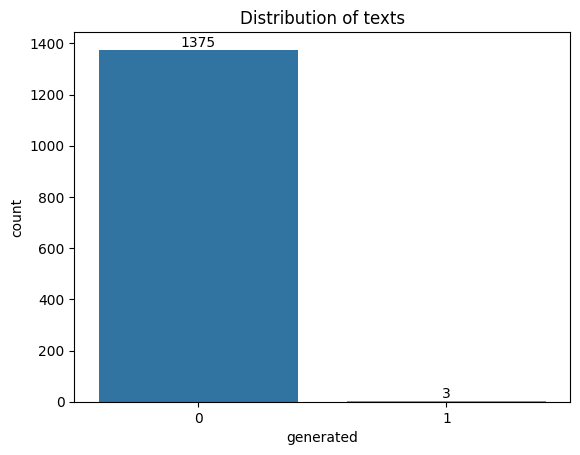

In [51]:
ax = sns.countplot(data=train_essays, x='generated')
ax.bar_label(ax.containers[0])
plt.title('Distribution of texts');

In [52]:
generated_essays = train_essays[train_essays['generated'] == 1]
generated_essays

,id,prompt_id,text,generated,text_len
704,82131f68,1,"This essay will analyze, discuss and prove one...",1,1356
740,86fe4f18,1,I strongly believe that the Electoral College ...,1,1500
1262,eafb8a56,0,"Limiting car use causes pollution, increases c...",1,1797


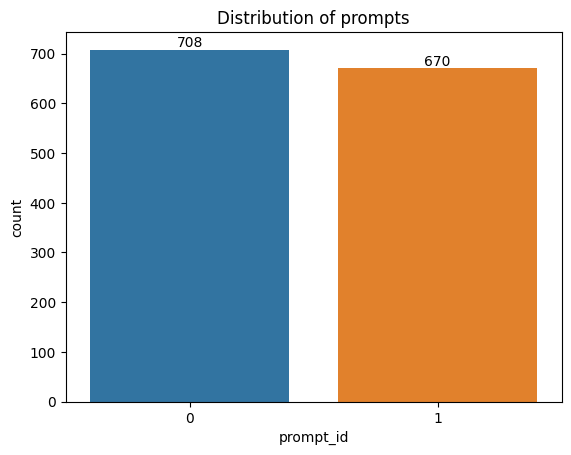

In [53]:
ax2 = sns.countplot(data=train_essays, x='prompt_id')
ax2.bar_label(ax2.containers[0])
plt.title('Distribution of prompts');

### Exploring test_essays

In [54]:
test_essays

,id,prompt_id,text
0,0000aaaa,2,Aaa bbb ccc.
1,1111bbbb,3,Bbb ccc ddd.
2,2222cccc,4,CCC ddd eee.


There is only dummy data in test_essays, after submission the text will be replaced with real text.

### Exploring Train Prompts data

In [55]:
train_prompts

,prompt_id,prompt_name,instructions,source_text
0,0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ..."
1,1,Does the electoral college work?,Write a letter to your state senator in which ...,# What Is the Electoral College? by the Office...


In [56]:
train_prompts.iloc[0]['instructions']

'Write an explanatory essay to inform fellow citizens about the advantages of limiting car usage. Your essay must be based on ideas and information that can be found in the passage set. Manage your time carefully so that you can read the passages; plan your response; write your response; and revise and edit your response. Be sure to use evidence from multiple sources; and avoid overly relying on one source. Your response should be in the form of a multiparagraph essay. Write your essay in the space provided.'

**Prompt_id = 0**\
**prompt_name = Car-free cities**\
'Write an explanatory essay to inform fellow citizens about the advantages of limiting car usage. Your essay must be based on ideas and information that can be found in the passage set. Manage your time carefully so that you can read the passages; plan your response; write your response; and revise and edit your response. Be sure to use evidence from multiple sources; and avoid overly relying on one source. Your response should be in the form of a multiparagraph essay. Write your essay in the space provided.'

In [57]:
train_prompts.iloc[1]['instructions']

'Write a letter to your state senator in which you argue in favor of keeping the Electoral College or changing to election by popular vote for the president of the United States. Use the information from the texts in your essay. Manage your time carefully so that you can read the passages; plan your response; write your response; and revise and edit your response. Be sure to include a claim; address counterclaims; use evidence from multiple sources; and avoid overly relying on one source. Your response should be in the form of a multiparagraph essay. Write your response in the space provided.'

**Prompt_id = 1**\
**prompt_name = Does the electoral college work?**\
'Write a letter to your state senator in which you argue in favor of keeping the Electoral College or changing to election by popular vote for the president of the United States. Use the information from the texts in your essay. Manage your time carefully so that you can read the passages; plan your response; write your response; and revise and edit your response. Be sure to include a claim; address counterclaims; use evidence from multiple sources; and avoid overly relying on one source. Your response should be in the form of a multiparagraph essay. Write your response in the space provided.'

## 3. Loading external dataset

Since there are only 3 AI generated essays, I need extra dataset with AI generated text.\
Luckily there is such data on Kaggle.

In [58]:
external_essays = pd.read_csv('/kaggle/input/daigt-v2-train-dataset/train_v2_drcat_02.csv')

In [59]:
external_essays.head(10)

,text,label,prompt_name,source,RDizzl3_seven
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,False
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,False
2,Driving while the use of cellular devices\n\nT...,0,Phones and driving,persuade_corpus,False
3,Phones & Driving\n\nDrivers should not be able...,0,Phones and driving,persuade_corpus,False
4,Cell Phone Operation While Driving\n\nThe abil...,0,Phones and driving,persuade_corpus,False
5,Cell phone use should not be legal while drivi...,0,Phones and driving,persuade_corpus,False
6,Phones and Driving\n\nDriving is a good way to...,0,Phones and driving,persuade_corpus,False
7,PHONES AND DRIVING\n\nIn this world in which w...,0,Phones and driving,persuade_corpus,False
8,People are debating whether if drivers should ...,0,Phones and driving,persuade_corpus,False
9,Texting and driving\n\nOver half of drivers in...,0,Phones and driving,persuade_corpus,False


In [60]:
external_essays['text_len'] = external_essays['text'].apply(len)
external_essays = external_essays.sort_values('text_len')
external_essays

,text,label,prompt_name,source,RDizzl3_seven,text_len
41204,"In recent years, there has been a growing trend",1,Distance learning,mistralai/Mistral-7B-Instruct-v0.1,False,48
40767,"Dear Senator,\n\nI am writing in support of k...",1,Does the electoral college work?,mistralai/Mistral-7B-Instruct-v0.1,True,272
41168,Car usage has long been a significant factor ...,1,Car-free cities,mistralai/Mistral-7B-Instruct-v0.1,True,273
41167,Limiting car usage is a concept that has gain...,1,Car-free cities,mistralai/Mistral-7B-Instruct-v0.1,True,304
34960,Passage 1:\n\nPassage 2:\n\nPassage 3:\n\nPass...,1,Seeking multiple opinions,falcon_180b_v1,False,314
...,...,...,...,...,...,...
8895,The author did not do a good job at supporting...,0,Exploring Venus,persuade_corpus,True,9980
19290,"Dear Senator,\n\nI favoring of keeping the Ele...",0,Does the electoral college work?,persuade_corpus,True,10309
1772,This passage is about a germany mom from the s...,0,Car-free cities,persuade_corpus,True,11641
2549,Imagen the streets with no cars empty with onl...,0,Car-free cities,persuade_corpus,True,18125


In [61]:
# Unique values in the columns
cols_unique = ['label', 'prompt_name', 'source','RDizzl3_seven']
for col in cols_unique:
    print(external_essays[col].unique())

[1 0]
['Distance learning' 'Does the electoral college work?' 'Car-free cities'
 'Seeking multiple opinions' 'Summer projects'
 'Facial action coding system' 'Mandatory extracurricular activities'
 'Grades for extracurricular activities' '"A Cowboy Who Rode the Waves"'
 'Cell phones at school' 'Community service' 'Exploring Venus'
 'Driverless cars' 'The Face on Mars' 'Phones and driving']
['mistralai/Mistral-7B-Instruct-v0.1' 'falcon_180b_v1' 'chat_gpt_moth'
 'mistral7binstruct_v2' 'llama2_chat' 'persuade_corpus'
 'mistral7binstruct_v1' 'cohere-command' 'llama_70b_v1' 'palm-text-bison1'
 'kingki19_palm' 'darragh_claude_v7' 'darragh_claude_v6' 'train_essays'
 'NousResearch/Llama-2-7b-chat-hf' 'radek_500' 'radekgpt4']
[False  True]


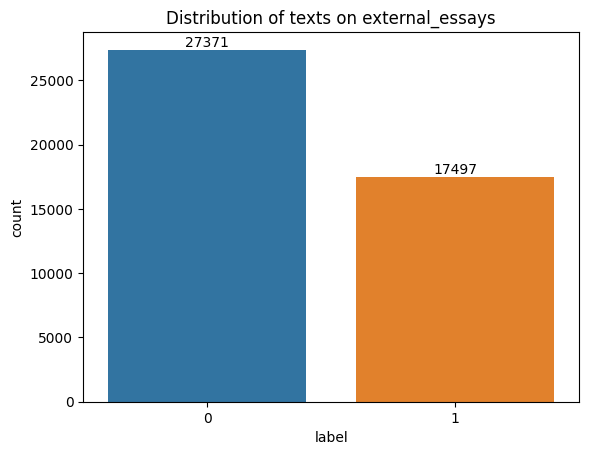

In [62]:
ax3 = sns.countplot(data=external_essays, x='label')
ax3.bar_label(ax3.containers[0])
plt.title('Distribution of texts on external_essays');

In [63]:
external_essays = external_essays.rename(columns={'label': 'generated'})

**Concatenating the datasets**

In [64]:
df = pd.concat([external_essays[['text', 'generated']], train_essays[['text', 'generated']]], ignore_index=True)

In [65]:
# df = df.sample(frac=0.02, random_state=42)

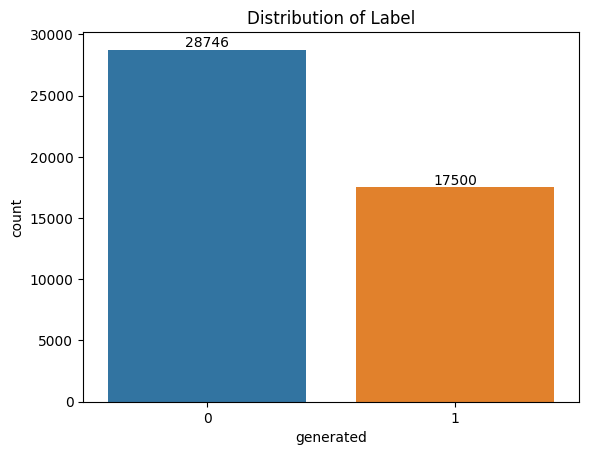

In [66]:
ax4 = sns.countplot(data=df, x='generated')
ax4.bar_label(ax4.containers[0])
plt.title('Distribution of Label');

In [67]:
df.head()

,text,generated
0,"In recent years, there has been a growing trend",1
1,"Dear Senator,\n\nI am writing in support of k...",1
2,Car usage has long been a significant factor ...,1
3,Limiting car usage is a concept that has gain...,1
4,Passage 1:\n\nPassage 2:\n\nPassage 3:\n\nPass...,1


**Clean text**

In [68]:
df.iloc[7][['text','generated']]

text         After researching extensively into different p...
generated                                                    1
Name: 7, dtype: object

In [69]:
def clean_text(text):
  #delete non-alphanumeric characters
  text = re.sub(r"[^A-Za-z0-9\s]", "", text)
  #delete extra whitespaces
  text = re.sub(r"\s+", " ", text)
  #convert to lowercase
  text = text.lower()

  return text

In [70]:
df['text'] = df['text'].map(clean_text)

In [71]:
df.iloc[7]['text']

'after researching extensively into different potential career paths i have shortlisted my top 5 options i have read up on the various qualifications responsibilities and other important aspects of each one and weighed them up against my skills and experience now i am planning to discuss my top 5 with my parents and teachers to get their opinions on which one could potentially benefit me the best'

## 4. Tokenizing

In [72]:
# checkpoint = '../input/transformers/distilbert-base-uncased'
checkpoint = 'distilbert/distilbert-base-uncased-finetuned-sst-2-english'

In [73]:
batch_size = 25

In [74]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [75]:
def tokenize_and_split(text):
    encoding = tokenizer(
        text["text"],
        truncation=True,
        padding=True,
        max_length=512,
        return_overflowing_tokens=True,
    )
    # Extract mapping between new and old indices
    sample_map = encoding.pop("overflow_to_sample_mapping")
    for key, values in text.items():
        encoding[key] = [values[i] for i in sample_map]
    return encoding

In [76]:
raw_ds = datasets.Dataset.from_pandas(df)
raw_ds = raw_ds.train_test_split(test_size=0.2)
raw_ds

DatasetDict({
    train: Dataset({
        features: ['text', 'generated'],
        num_rows: 36996
    })
    test: Dataset({
        features: ['text', 'generated'],
        num_rows: 9250
    })
})

In [77]:
tokenized_ds = raw_ds.map(tokenize_and_split, batched=True)

Map:   0%|          | 0/36996 [00:00<?, ? examples/s]

Map:   0%|          | 0/9250 [00:00<?, ? examples/s]

In [78]:
tokenized_ds

DatasetDict({
    train: Dataset({
        features: ['text', 'generated', 'input_ids', 'attention_mask'],
        num_rows: 45367
    })
    test: Dataset({
        features: ['text', 'generated', 'input_ids', 'attention_mask'],
        num_rows: 11267
    })
})

In [79]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

## 5. Modelling

In [80]:
tf_train_dataset = tokenized_ds['train'].to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols=["generated"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=batch_size,
)

tf_test_dataset = tokenized_ds['test'].to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols=["generated"],
    shuffle=False,
    collate_fn=data_collator,
    batch_size=batch_size,
)

/opt/conda/lib/python3.10/site-packages/datasets/arrow_dataset.py:399: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


In [81]:
num_epochs = 2

In [82]:
model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2, from_pt=True)

All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


In [83]:
# The number of training steps is the number of samples in the dataset, divided by the batch size then multiplied
# by the total number of epochs. Note that the tf_train_dataset here is a batched tf.data.Dataset,
# not the original Hugging Face Dataset, so its len() is already num_samples // batch_size.
num_train_steps = len(tf_train_dataset) * num_epochs
lr_scheduler = PolynomialDecay(
    initial_learning_rate=5e-5, end_learning_rate=0.0, decay_steps=num_train_steps
)

opt = Adam(learning_rate=lr_scheduler)

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

es = EarlyStopping(monitor='val_loss', patience=1, verbose=1, mode='auto', restore_best_weights=True)

callback = PushToHubCallback(
    "LLM_generated_text_detector", save_strategy="no", tokenizer=tokenizer
)

/opt/conda/lib/python3.10/site-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'Repository' (from 'huggingface_hub.repository') is deprecated and will be removed from version '1.0'. Please prefer the http-based alternatives instead. Given its large adoption in legacy code, the complete removal is only planned on next major release.
For more details, please read https://huggingface.co/docs/huggingface_hub/concepts/git_vs_http.
  warnings.warn(warning_message, FutureWarning)
/kaggle/working/LLM_generated_text_detector is already a clone of https://huggingface.co/Wintersmith/LLM_generated_text_detector. Make sure you pull the latest changes with `repo.git_pull()`.


In [84]:
model.compile(optimizer=opt, loss=loss, metrics=["accuracy"])

In [85]:
model.fit(tf_train_dataset, validation_data=tf_test_dataset, epochs=num_epochs, callbacks=[es, callback])

Epoch 1/2
1815/1815 [==============================] - 2812s 2s/step - loss: 0.0579 - accuracy: 0.9809 - val_loss: 0.0272 - val_accuracy: 0.9920
Epoch 2/2
1815/1815 [==============================] - 2790s 2s/step - loss: 0.0082 - accuracy: 0.9974 - val_loss: 0.0191 - val_accuracy: 0.9941


Upload file tf_model.h5:   0%|          | 1.00/256M [00:00<?, ?B/s]

To https://huggingface.co/Wintersmith/LLM_generated_text_detector
   9aa28a0..f4838f7  main -> main



In [86]:
#model.save_pretrained("/kaggle/working/model_trained", saved_model=True)


## 6. Evaluation

In [87]:
preds = model.predict(tf_test_dataset)["logits"]

y_pred = np.argmax(preds, axis=1)
print(preds.shape, y_pred.shape)

y_pred

#y_true = np.concatenate([y for x, y in tf_test_dataset], axis=0)
# https://stackoverflow.com/questions/56226621/how-to-extract-data-labels-back-from-tensorflow-dataset

451/451 [==============================] - 221s 486ms/step
(11267, 2) (11267,)


array([1, 0, 0, ..., 1, 1, 0])

In [88]:
def get_probabilities(input_text):
    logits_pred = model.predict(input_text)['logits']
    probs = tf.nn.sigmoid(logits_pred)
    class_1_probability = probs[:, 1].numpy()
    return class_1_probability

In [89]:
y_prob = get_probabilities(tf_test_dataset)
y_prob

451/451 [==============================] - 219s 486ms/step


array([0.9966794 , 0.01150257, 0.01455727, ..., 0.99643433, 0.99624926,
       0.03235682], dtype=float32)

In [90]:
y_true = np.concatenate([y for x, y in tf_test_dataset], axis=0)

In [91]:
def evaluate_model(y_true, y_pred):
  print(ConfusionMatrixDisplay.from_predictions(y_true, y_pred))
  print(classification_report(y_true, y_pred))
  print('F1 score:', f1_score(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      7613
           1       0.99      0.99      0.99      3654

    accuracy                           0.99     11267
   macro avg       0.99      0.99      0.99     11267
weighted avg       0.99      0.99      0.99     11267

F1 score: 0.9908457439540921


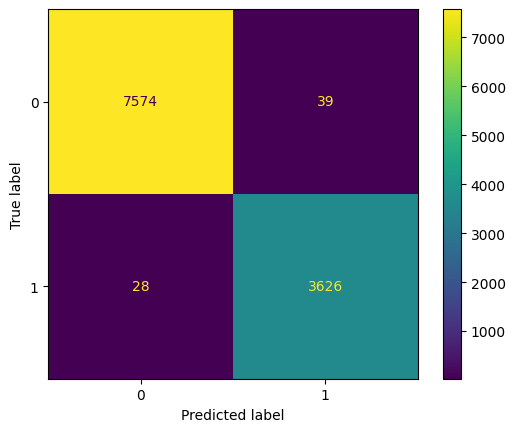

In [92]:
evaluate_model(y_true=y_true, y_pred=y_pred)

## 7. Submitting predictions on test set

In [93]:
test_essays


,id,prompt_id,text
0,0000aaaa,2,Aaa bbb ccc.
1,1111bbbb,3,Bbb ccc ddd.
2,2222cccc,4,CCC ddd eee.


In [94]:
test_essays['text'] = test_essays['text'].map(clean_text)


In [95]:
raw_final_ds = datasets.Dataset.from_pandas(test_essays)
raw_final_ds

Dataset({
    features: ['id', 'prompt_id', 'text'],
    num_rows: 3
})

In [96]:
tokenized_test_dataset = raw_final_ds.map(tokenize_and_split, batched=True)
tokenized_test_dataset

Map:   0%|          | 0/3 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'prompt_id', 'text', 'input_ids', 'attention_mask'],
    num_rows: 3
})

In [97]:
tf_final_dataset = tokenized_test_dataset.to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    #label_cols=["target"],
    shuffle=False,
    collate_fn=data_collator,
    batch_size=batch_size,
)

In [98]:
class_1_final_probability = get_probabilities(tf_final_dataset)

1/1 [==============================] - 2s 2s/step


In [99]:
sample_submission["generated"] = class_1_final_probability

In [100]:
sample_submission.to_csv("/kaggle/working/submission.csv", index=False)

## 8. Predict one sentence

In [101]:
# sequence_text = input your own text
sequence_text = raw_ds['test']['text'][15]
print(f"Label: {raw_ds['test']['generated'][15]}")
print(f"Text:\n {sequence_text}")

Label: 0
Text:
 to principal students should not be able to have or do community service if they where not convicted of a crime they committed in school of on school grounds community service is understandable to me but its not fair to have students help out others if they werent convicted of bad behavior an example to that u cant order a student to do community service for himher for picking up trash another student dropped in the hallway in addition to that students have the rite to do community service if not given to himher but if community service is given then heshe should be punished for there actions but what did they do to deserve community service some students should be punished for bad behavior talking back even just being plan out disrespectful to one another but what they shouldnt have community service for is helping out another person when they are caught in the act of someone else being mean to himher also being a good character to the school classmates teachers staff 

In [102]:
sequence = sequence_text
model_input = tokenizer(sequence, max_length=512, padding=True, truncation=True, return_tensors='tf')
model_input = dict(model_input)

In [103]:
get_probabilities(model_input)

1/1 [==============================] - 2s 2s/step


array([0.01741369], dtype=float32)